In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython pyyaml==5.1

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [1]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
import os

setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "/kaggle/input/df2-train-img/ann_train.json", "/kaggle/input/df2-train-img/train_image/image")


In [3]:
class AdamTrainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        return torch.optim.Adam(
            model.parameters(),
            lr=cfg.SOLVER.BASE_LR
        )

In [4]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml") 


# cfg.MODEL.BACKBONE.FREEZE_AT = 2
# cfg.MODEL.RPN.NMS_THRESH = 0.7
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = int(0.2*cfg.SOLVER.MAX_ITER)
cfg.SOLVER.MAX_ITER = 4000  # Подходит для большого датасета
cfg.SOLVER.STEPS = (1500, 3000)
cfg.SOLVER.GAMMA = 0.05
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13

cfg.TEST.EVAL_PERIOD = 500
cfg.OUTPUT_DIR = "/kaggle/working"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [5]:
trainer = AdamTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/08 09:29:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/08 09:33:34 d2.utils.events]:  eta: 3:10:29  iter: 19  total_loss: 3.807  loss_cls: 2.537  loss_box_reg: 0.5547  loss_mask: 0.6941  loss_rpn_cls: 0.01999  loss_rpn_loc: 0.01746    time: 2.7017  last_time: 2.5397  data_time: 0.0439  last_data_time: 0.0090   lr: 1.0071e-06  max_mem: 11356M
[11/08 09:34:30 d2.utils.events]:  eta: 2:52:35  iter: 39  total_loss: 3.768  loss_cls: 2.358  loss_box_reg: 0.7128  loss_mask: 0.6935  loss_rpn_cls: 0.01918  loss_rpn_loc: 0.01651    time: 2.6483  last_time: 2.7896  data_time: 0.0142  last_data_time: 0.0184   lr: 1.0146e-06  max_mem: 11356M
[11/08 09:35:23 d2.utils.events]:  eta: 2:52:08  iter: 59  total_loss: 3.507  loss_cls: 2.088  loss_box_reg: 0.718  loss_mask: 0.6927  loss_rpn_cls: 0.02028  loss_rpn_loc: 0.01651    time: 2.6523  last_time: 2.3185  data_time: 0.0111  last_data_time: 0.0115   lr: 1.0221e-06  max_mem: 11356M
[11/08 09:36:17 d2.utils.events]:  eta: 2:51:36  iter: 79  total_loss: 3.182  loss_cls: 1.682  loss_box_reg: 0.6932  loss_

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # set the testing threshold for this model
cfg.DATASETS.TEST = ("deepfashion_train", )
predictor = DefaultPredictor(cfg)

[11/08 12:38:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

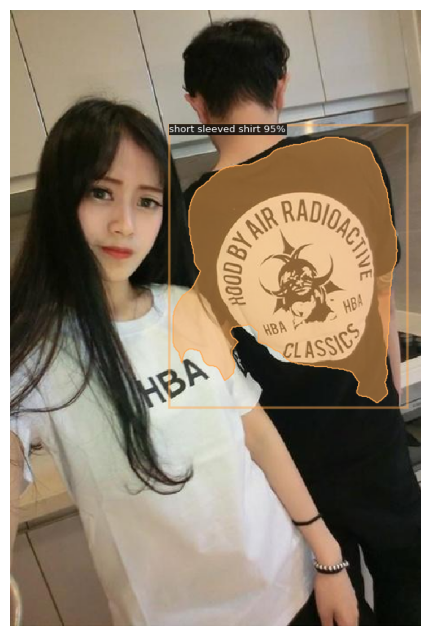

In [20]:
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Чтение изображения в формате RGB
im = cv2.cvtColor(cv2.imread("/kaggle/input/df2-train-img/train_image/image/000002.jpg"), cv2.COLOR_BGR2RGB)

# Получение предсказаний от модели
outputs = predictor(im)

# Визуализация предсказаний
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Использование matplotlib для отображения изображения
plt.figure(figsize=(12, 8))
plt.imshow(v.get_image()[:, :, ::-1])  # Изображение уже в формате RGB, поэтому конвертация не требуется
plt.axis("off")  # Скрыть оси
plt.show()

In [21]:
torch.save(trainer.model, 'checkpoint.pth')

In [26]:
from IPython.display import FileLink

FileLink("checkpoint.pth")

/kaggle/working/checkpoint.pth